# Implementation of time blocking for compression/serialization and de-serialization/de-compression of wavefields with Devito operators

## Compression note -- use of ```blosc```

In this notebook we use ```blosc``` compression that is not loaded by default in devito. The first operational cell in the notebook uses the jupyter notebook *magic* command shown below to install the ```blosc``` compression library and python wrapper, which may require compilation. 

```
import sys
!{sys.executable} -m pip install blosc
```

Note that ```blosc``` provides *lossless compression*, and in practice one uses *lossy compression* to achieve significantly better compression ratios. Consider the use of ```blosc``` as a placeholder for your compression method of choice, providing all essential characteristics of what might be used at scale. 

```blosc``` Reference:
* c project and library: https://blosc.org
* python wrapper: https://github.com/Blosc/python-blosc
* python wrapper documentation: http://python-blosc.blosc.org

## Introduction 

The goal of this tutorial is to prototype the compression/serialization and de-serialization/de-compression for wavefields in Devito. The motivation is using seismic modeling operators for full waveform inversion (FWI). Some of the steps in FWI require the use of previsouly computed wavefields, and of particular interest the adjoint of the Jacobian linearized operator -- an operator that maps data perturbation into velocity perturbation -- requires a zero-lag temporal correlation with the wavefield that is computed with the nonlinear source. 

There are implemented alternatives to serialization/de-serialization like checkpointing (link to nb?), but we investigate the serialization option here. 

We aim to provide a *proof of concept* for compression/serialization and de-serialization/de-compression of the nonlinear wavefield. We will achieve this via _time blocking_: we will run a number of time steps in the generated c kernel, and then return control to python for compression/serialization and de-serialization/de-compression operations.

In order to illustrate the use case for serialization, we write the workflow for computing the gradient of the FWI objective function, ignoring a lot of details, as follows:

1. Generate the nonlinear forward modeled data at the receivers $d_{mod}$
$$ 
d_{mod} = F m 
$$

1. Compress and serialize the nonlinear source wavefield to disk during computation of 1. The entire nonlinear wavefield is of size $[nt,nx,nz]$ in 2D, but we deal with a block of $M$ time steps at a time, so the size of the chunk to be compressed and serialized is $[M,nx,nz]$. 

1. Compute the data residual $\delta r$ by differencing observed and modeled data at the receivers 
$$
\delta r = d_{obs} - d_{mod}
$$

1. Backproject the data residual $\delta r$ via time reversal with the adjoint linearized Jacobian operator.

1. De-serialize and de-compress the nonlinear source wavefield from disk during computation in step 4, synchronizing time step between the nonlinear wavefield computed forward in time and time reversed adjoint wavefield. We will deal with de-serialization and de-compression of chunks of $M$ time steps of size $[M,nx,nz]$.

1. Increment the model perturbation via zero lag correlation of the de-serialized nonlinear source wavefield and the backprojected receiver adjoint wavefield. Note that this computed model perturbation is the  _gradient_ of the FWI objective function.
$$
\delta m = \bigl( \nabla F\bigr)^\top\ \delta r
$$

Please see other notebooks in this directory for more details, in particular the notebooks describing the self-adjoint modeling operators. More information: 
* Nonlinear operator ([sa_01_iso_implementation1.ipynb](sa_01_iso_implementation1.ipynb))
* Linearized operators ([sa_02_iso_implementation2.ipynb](sa_02_iso_implementation2.ipynb)).

## Outline 
1. Define symbols
1. Description of tests to verify correctness
1. Description of use of ```Buffer``` in ```TimeFunction``` to implement time blocking
1. Ensure ```python-blosc``` compression is installed
1. Create small 2D test model
1. Implement and test the Nonlinear forward operation
  - Save all time steps 
  - Time blocking plus compression/serialization
  - Ensure differences are at machine epsilon 
1. Implement and test the Jacobian linearized forward operation
  - Save all time steps 
  - Time blocking plus compression/serialization
  - Ensure differences are at machine epsilon 
1. Implement and test theJacobian linearized adjoint operation
  - Save all time steps 
  - Time blocking plus compression/serialization
  - Ensure differences are at machine epsilon 
1. Discussion

## Table of symbols

We show the symbols here relevant to the implementation of the linearized operators.

| Symbol &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Description  | Dimensionality | 
|:---|:---|:---|
| $m_0(x,y,z)$ | Reference P wave velocity    | function of space |
| $\delta m(x,y,z)$ | Perturbation to P wave velocity    | function of space |
| $u_0(t,x,y,z)$ | Reference pressure wavefield | function of time and space |
| $\delta u(t,x,y,z)$ | Perturbation to pressure wavefield | function of time and space |
| $s(t,x,y,z)$ | Source wavefield | function of time, localized in space to source location |
| $r(t,x,y,z)$ | Receiver wavefield | function of time, localized in space to receiver locations |
| $\delta r(t,x,y,z)$ | Receiver wavefield perturbation | function of time, localized in space to receiver locations |
| $F[m]\ q$ | Forward linear modeling operator | Nonlinear in $m$, linear in $q, s$: $\quad$ maps $q \rightarrow s$ |
| $F[m; q]$ | Forward nonlinear modeling operator | Nonlinear in $m$, linear in $q$: $\quad$ maps $m \rightarrow r$ |
| $\nabla F[m; q]\ \delta m$ | Forward Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta m \rightarrow \delta r$ |
| $\bigl( \nabla F[m; q] \bigr)^\top\ \delta r$ | Adjoint Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta r \rightarrow \delta m$ |

## Description of tests to verify correctness

In order to make sure we have implemented these operators correctly, we will numerically compare the output from two runs:
1. all time steps saved implementation 
1. time blocking plus compression/serialization implementation

We perform these tests for three phases of FWI modeling:
1. nonlinear forward (maps model to data)
1. Jacobian linearized forward (maps model perturbation to data perturbation)
1. Jacobian linearized adjoint (maps data perturbation to model perturbation)

We will design the small 2D test experiment with a source in the middle of the model and short enough elapsed modeling time that we do not need to worry about boundary reflections for these tests. 

## Use of ```Buffer``` to implement time blocking

We will use a ```Buffer``` of size $M$ in our time blocking implementation. This means that space is allocated for spatial wavefields at $M$ time steps, each spatial wavefield of size $[nx,nz]$. The ```Buffer``` then cycles through the allocated time steps as the modeling evolves, using *modulo indexing*. 

### Modulo indexing for a second order in time PDE
Below we demonstrate time blocking with a second order in time PDE, which requires two wavefields in order to advance in time. In a second order system the wavefield at the next time step $u(t+\Delta t)$ is defined as a function of the wavefield at current time step $u(t)$ and the wavefield at previous time step $u(t-\Delta t)$.

Devito uses modulo indexing with ```Buffer``` for indexing into $u$ of fixed size. We show below the code generated by devito for a ```Buffer``` of size 5, with time indices ```t0``` (current time step), ```t1``` (next time step), and ```t2``` (previous time step) as a function of the temporal loop index ```time```. Note that we have simplified the generated code by breaking a single for loop specification line into multiple lines for clarity. We have also added comments to help understand the mapping of indices.

```
for (int time = time_m; time <= time_M; time += 1) {
  t0 = (time + 0)%(5);    // time index for the current time step 
  t1 = (time + 1)%(5);    // time index for the next time step
  t2 = (time + 4)%(5);    // time index for the  previous time step
  
  // ... PIE: propagation, source injection, receiver extraction ...
}

```

It is important to note that for a second order system the minimum allowed time index ```time_m``` will be $1$, because starting at $0$ would imply that the previous time step wavefield $u(t-\Delta t)$ exists at time index $-1$. 

It is also obvious the maximum allowed loop index ```time_M``` is *inclusive*, and so must be $\le (nt-1)$.

### Demonstration of modulo indexing for a sequence of time steps

We next look at the time indices for a sequence of 15 time steps starting from time index $1$. We are blocking $M=5$ time steps, so the ```TimeFunction``` for the wavefield $u$ was initialized as ```u = TimeFunction(..., Buffer(5))```. We will show the loop index for time steps ```time``` and the modulo 5 time indices ```t0```, ```t1```, ```t2```, with the time blocking intervals of $M$ time steps each demarcated with horizontal lines. 

$$
\scriptsize
\begin{matrix}
\text{time block} & & \text{time} & & \text{modulo t0} & & \text{modulo t1} & & \text{modulo t2} \\ 
\hline
  & \; &  1 & \; &  1 & \; &  2 & \; &  0 \\
  & \; &  2 & \; &  2 & \; &  3 & \; &  1 \\
1 & \; &  3 & \; &  3 & \; &  4 & \; &  2 \\
  & \; &  4 & \; &  4 & \; &  0 & \; &  3 \\
  & \; &  5 & \; &  0 & \; &  1 & \; &  4 \\
\hline
  & \; &  6 & \; &  1 & \; &  2 & \; &  0 \\
  & \; &  7 & \; &  2 & \; &  3 & \; &  1 \\
2 & \; &  8 & \; &  3 & \; &  4 & \; &  2 \\
  & \; &  9 & \; &  4 & \; &  0 & \; &  3 \\
  & \; & 10 & \; &  0 & \; &  1 & \; &  4 \\
\hline
  & \; & 11 & \; &  1 & \; &  2 & \; &  0 \\
  & \; & 12 & \; &  2 & \; &  3 & \; &  1 \\
3 & \; & 13 & \; &  3 & \; &  4 & \; &  2 \\
  & \; & 14 & \; &  4 & \; &  0 & \; &  3 \\
  & \; & 15 & \; &  0 & \; &  1 & \; &  4 \\
\hline
\end{matrix}
$$

Observe how the modulo time index ```t1``` for the next time step $u(t+\Delta t)$ is one more than the time index ```t0``` for the current time step $u(t)$, and the modulo time index ```t2``` for the previous time step $u(t-\Delta t)$ is one less than the time index ```t0``` for the current time step $u(t)$, with the exception of when modulo indexing for the ```Buffer``` wraps around.

What is most important about this is recognizing when the modulo indiexing wraps around for a ```Buffer``` of particular size. The practical outcome is that if you start from time index 1 and assign a block of $M$ time steps computed using ```Buffer``` to a contiguous array (or disk storage) you will need use two assignment statements, for example:
 1. modulo indices 1 through 4, the first four time steps, which map to ```Buffer``` indicies 1-4.
 2. modulo index M, which maps to ```Buffer``` index 0

### Considerations for correctness testing and serialization 

For the purpose of testing correctness against a wavefield computed by saving all time steps, we will use the two assignment statements as shown above to assign all $M$ times slices from the ```Buffer```. 

However, when we compress and serialize it makes sense to use the block of $M$ time steps in the ```Buffer``` directly with a single assignment, even if not contiguous in time. There may be some small impact on compression due to the discontinuity associated with ```Buffer``` element 0 corresponding to time index 5 and ```Buffer``` element 1 corresponding to time index 1. We have not explored this and will ignore for the purpose of this notebook.

## Ensure that ```blosc``` is installed

In [1]:
# Install pyzfp package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install blosc

## Imports 

We have grouped all imports used in this notebook here for consistency.

In [2]:
from scipy.special import hankel2
import numpy as np
from examples.seismic import RickerSource, Receiver, TimeAxis, Model, AcquisitionGeometry
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve, configuration, norm, Buffer)
from devito.finite_differences import Derivative
from devito.builtins import gaussian_smooth
from examples.seismic.self_adjoint import (acoustic_sa_setup, setup_w_over_q,
                                           SaIsoAcousticWaveSolver)
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# Make white background for plots, not transparent
plt.rcParams['figure.facecolor'] = 'white'

# Set logging to debug, captures statistics on the performance of operators
# configuration['log-level'] = 'DEBUG'
configuration['log-level'] = 'INFO'

## Instantiate the model for a two dimensional problem
 - We use a small 500x500 m. model
 - We use 10x10 m. discretization 
 - We choose modeling sample rate explicitly (2 msec)
 - We use a modeling time range of 1 second
 - We use a wholespace model
   - velocity: 1500 m/s
   - density: 1 g/cm^3
 - We place the source in the center of the model
 - We use a vertical line of receivers right of center in model
 - We use the visco-acoustic absorbing boundary logic from the self-adjoint operators linked above, and add a 50 point absorbing boundary
 - We also generate a velocity perturbation that will be used in the linearized forward Jacobian operator

In [3]:
# NBVAL_IGNORE_OUTPUT

# Define dimensions for the interior of the model
nx,nz = 501,501
npad = 50
dx,dz = 10.0,10.0  # Grid spacing in m
shape = (nx, nz)   # Number of grid points
spacing = (dx, dz) # Domain size is now 5 km by 5 km
origin = (0., 0.)  # Origin of coordinate system, specified in m.
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])

# Define the dimensions 
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))

# Initialize the Devito grid 
dtype = np.float64
grid = Grid(extent=extent, shape=shape, origin=origin, dimensions=(x, z), dtype=dtype)

print("shape;           ", shape)
print("origin;          ", origin)
print("spacing;         ", spacing)
print("extent;          ", extent)

print("")
print("grid.shape;      ", grid.shape)
print("grid.extent;     ", grid.extent)
print("grid.spacing_map;", grid.spacing_map)

# Create velocity and buoyancy fields. 
space_order = 8
m0 = Function(name='m0', grid=grid, space_order=space_order)
b = Function(name='b', grid=grid, space_order=space_order)
m0.data[:] = 1.5
b.data[:,:] = 1.0 / 1.0

# Perturbation to velocity: a square offset from the center of the model
dm = Function(name='dm', grid=grid, space_order=space_order)
size = 10
x0 = (nx-1)//2
z0 = (nz-1)//2
dm.data[:] = 0.0
dm.data[x0-size:x0+size, z0-size:z0+size] = 1.0

# Initialize the attenuation profile for the absorbing boundary
fpeak = 0.010
w = 2.0 * np.pi * fpeak
qmin = 0.1
wOverQ = Function(name='wOverQ_025', grid=grid, space_order=space_order)
setup_w_over_q(wOverQ, w, qmin, 100.0, npad)

# Time sampling
t0 = dtype(0)     # Simulation time start
tn = dtype(500)  # Simulation time end (1 second = 1000 msec)
dt = dtype(2)
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num
print("")
print("time_range; ", time_range)

# Source in the center of the model at 10 Hz center frequency
# Note we make two copes, one for save all and one for  time blocking
src1 = RickerSource(name='src1', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src2 = RickerSource(name='src2', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src1.coordinates.data[0,0] = dx * ((nx-1) / 2 - 20)
src1.coordinates.data[0,1] = dz * (nz-1) / 2
src2.coordinates.data[0,0] = dx * ((nx-1) / 2 - 20)
src2.coordinates.data[0,1] = dz * (nz-1) / 2

# line of receivers along the right edge of the model
# Note we make two copes, one for save all and one for  time blocking
rec1 = Receiver(name='rec1', grid=grid, npoint=nz, time_range=time_range)
rec1.coordinates.data[:,0] = dx * ((nx-1) / 2 + 20)
rec1.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

rec2 = Receiver(name='rec2', grid=grid, npoint=nz, time_range=time_range)
rec1.coordinates.data[:,0] = dx * ((nx-1) / 2 + 20)
rec2.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

print("")
print("src_coordinate  X;         %+12.4f" % (src1.coordinates.data[0,0]))
print("src_coordinate  Z;         %+12.4f" % (src2.coordinates.data[0,1]))
print("rec_coordinates X min/max; %+12.4f %+12.4f" % \
      (np.min(rec1.coordinates.data[:,0]), np.max(rec1.coordinates.data[:,0])))
print("rec_coordinates Z min/max; %+12.4f %+12.4f" % \
      (np.min(rec1.coordinates.data[:,1]), np.max(rec1.coordinates.data[:,1])))

shape;            (501, 501)
origin;           (0.0, 0.0)
spacing;          (10.0, 10.0)
extent;           (5000.0, 5000.0)

grid.shape;       (501, 501)
grid.extent;      (5000.0, 5000.0)
grid.spacing_map; {h_x: 10.0, h_z: 10.0}


Operator `WOverQ_Operator` run in 0.01 s



time_range;  TimeAxis: start=0, stop=500, step=2, num=251

src_coordinate  X;           +2300.0000
src_coordinate  Z;           +2500.0000
rec_coordinates X min/max;   +2700.0000   +2700.0000
rec_coordinates Z min/max;      +0.0000   +5000.0000


## Plot velocity and density models

Next we plot the velocity and density models for illustration, with source location shown as a large red asterisk and receiver line shown as a black line.

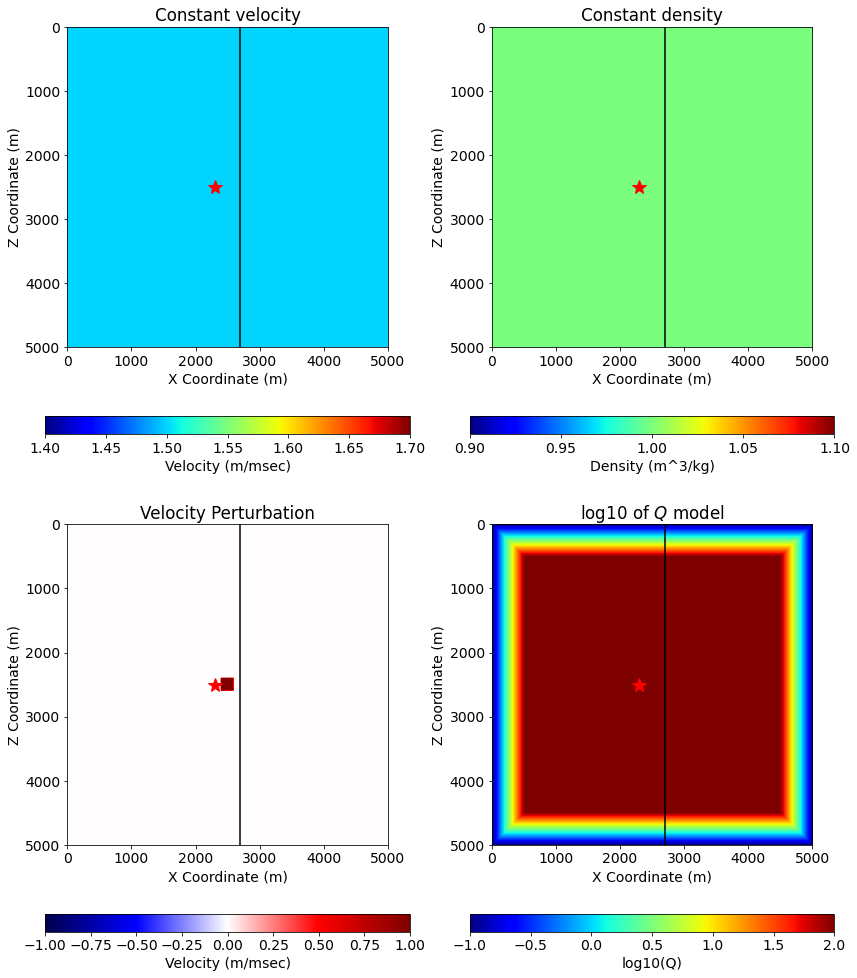

In [4]:
# note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin[0], origin[0] + extent[0], origin[1] + extent[1], origin[1]]

vmin, vmax = 1.4, 1.7
pmin, pmax = -1, +1
dmin, dmax = 0.9, 1.1

plt.figure(figsize=(12,14))

# plot velocity 
plt.subplot(2, 2, 1)
plt.imshow(np.transpose(m0.data), cmap=cm.jet, 
           vmin=vmin, vmax=vmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.plot(rec1.coordinates.data[:, 0], rec1.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src1.coordinates.data[:, 0], src1.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Constant velocity")

# plot density
plt.subplot(2, 2, 2)
plt.imshow(np.transpose(1 / b.data), cmap=cm.jet,
           vmin=dmin, vmax=dmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Density (m^3/kg)')
plt.plot(rec1.coordinates.data[:, 0], rec1.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src1.coordinates.data[:, 0], src1.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Constant density")

# plot velocity perturbation
plt.subplot(2, 2, 3)
plt.imshow(np.transpose(dm.data), cmap="seismic", 
           vmin=pmin, vmax=pmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.plot(rec1.coordinates.data[:, 0], rec1.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src1.coordinates.data[:, 0], src1.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Velocity Perturbation")

# Plot the log of the generated Q profile
q = np.log10(w / wOverQ.data)
lmin, lmax = np.log10(qmin), np.log10(100)

plt.subplot(2, 2, 4)
plt.imshow(np.transpose(q.data), cmap=cm.jet, vmin=lmin, vmax=lmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='log10(Q)')
plt.plot(rec1.coordinates.data[:, 0], rec1.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src1.coordinates.data[:, 0], src1.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("log10 of $Q$ model")

plt.tight_layout()
None

## Time blocking implementation of nonlinear forward

### Save all time steps implementation

We borrow the stencil from the self-adjoint operators shown in the jupyter notebooks linked above. 

When we instantiate the ```TimeFunction``` $u$ we pass the argument ```save=nt``` which allocates memory for ```nt``` time steps.

In [5]:
# NBVAL_IGNORE_OUTPUT

# Create a TimeFunction saving all time steps
u1 = TimeFunction(name="u1", grid=grid, time_order=2, space_order=space_order, save=nt)
t,x,z = u1.dimensions

# Source terms (see notebooks linked above for more detail)
src1_term = src1.inject(field=u1.forward, expr=src1 * t.spacing**2 * m0**2 / b)
rec1_term = rec1.interpolate(expr=u1.forward)

# Time update equation (see notebooks linked above for more detail)
eq_time_update1 = (t.spacing**2 * m0**2 / b) * \
    ((b * u1.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) + \
     (b * u1.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2)) + \
    (2 - t.spacing * wOverQ) * u1 + \
    (t.spacing * wOverQ - 1) * u1.backward

stencil1 = Eq(u1.forward, eq_time_update1)

# Update spacing_map (see notebooks linked above for more detail)
spacing_map = grid.spacing_map
spacing_map.update({t.spacing : dt})
print("spacing_map; ", spacing_map)

# Build and run the Operator
# Note the first time sample we run is 1, and the last is nt-2 
op1 = Operator([stencil1] + src1_term + rec1_term, subs=spacing_map)
op1(time_m=1, time_M=nt - 2)
# print(op1)

spacing_map;  {h_x: 10.0, h_z: 10.0, dt: 2.0}


Operator `Kernel` run in 0.52 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.5077540000000003, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=7.899999999999987e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.0020709999999999973, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [6]:
# NBVAL_IGNORE_OUTPUT

# Continuous integration hooks 
# We ensure the norm of these computed wavefields is repeatable
print(norm(u1))
print(norm(rec1))
assert np.isclose(norm(u1), 2229.983, atol=0, rtol=1e-3)
assert np.isclose(norm(rec1), 154.825, atol=0, rtol=1e-3)

2229.983497754759
154.8253378402296


### Time blocking implementation

We now will instantiate a ```TimeFunction``` $u2$ that uses a ```Buffer``` for saving time steps. We choose the buffer size $M$, hopefully a reasonable number in practice that would allow time-tiling but still not create too large a memory footprint for $u2$.

In [7]:
# Create a TimeFunction using a Buffer to save only M time steps
M = 5
u2 = TimeFunction(name="u2", grid=grid, time_order=2, space_order=space_order, save=Buffer(M))

# Source and receiver terms (see notebooks linked above for more detail)
src2_term = src2.inject(field=u2.forward, expr=src2 * t.spacing**2 * m0**2 / b)
rec2_term = rec2.interpolate(expr=u2.forward)

# We need to regenerate the time update equation with the new TimeFunction in order
# to get the time handling correct
eq_time_update2 = (t.spacing**2 * m0**2 / b) * \
    ((b * u2.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) + \
     (b * u2.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2)) + \
    (2 - t.spacing * wOverQ) * u2 + \
    (t.spacing * wOverQ - 1) * u2.backward

stencil2 = Eq(u2.forward, eq_time_update2)

# Update spacing_map (see notebooks linked above for more detail)
spacing_map = grid.spacing_map
spacing_map.update({t.spacing : dt})
print("spacing_map; ", spacing_map)

# Build the Operator 
op2 = Operator([stencil2] + src2_term + rec2_term, subs=spacing_map)
# print(op2)

spacing_map;  {h_x: 10.0, h_z: 10.0, dt: 2.0}


### Run loop over blocks of M time steps

Here we will run over blocks of $M$ time steps, where:
* the total number of time steps $nt$ 
* the number of time steps in a time block $M$ 
* the total number of time blocks is $N = 1 + (nt-1)\ /\ M$

$$
\scriptsize
\begin{matrix}
\text{time block} & & \text{time} & & \text{modulo t0} & & \text{modulo t1} & & \text{modulo t2} \\ 
\hline
  & \; &  1 & \; &  1 & \; &  2 & \; &  0 \\
  & \; &  2 & \; &  2 & \; &  3 & \; &  1 \\
1 & \; &  3 & \; &  3 & \; &  4 & \; &  2 \\
  & \; &  4 & \; &  4 & \; &  0 & \; &  3 \\
  & \; &  5 & \; &  0 & \; &  1 & \; &  4 \\
\hline
  & \; &  6 & \; &  1 & \; &  2 & \; &  0 \\
  & \; &  7 & \; &  2 & \; &  3 & \; &  1 \\
2 & \; &  8 & \; &  3 & \; &  4 & \; &  2 \\
  & \; &  9 & \; &  4 & \; &  0 & \; &  3 \\
  & \; & 10 & \; &  0 & \; &  1 & \; &  4 \\
\hline
  & \; & 11 & \; &  1 & \; &  2 & \; &  0 \\
  & \; & 12 & \; &  2 & \; &  3 & \; &  1 \\
3 & \; & 13 & \; &  3 & \; &  4 & \; &  2 \\
  & \; & 14 & \; &  4 & \; &  0 & \; &  3 \\
  & \; & 15 & \; &  0 & \; &  1 & \; &  4 \\
\hline
\end{matrix}
$$

In [31]:
# NBVAL_IGNORE_OUTPUT

# We make an array the full size in order to save the time blocked wavefield
# for comparison with u1 above
u2_all = np.zeros(u1.data.shape, dtype=dtype)

# Number of time blocks
N = (nt - 1) / M + 1
print("nt,M,N; %3d %3d %3d" % (nt, M, N))

# Open a binary file in append mode to save the wavefield chunks  
filename = "timeblocking.nonlinear.bin"
f = open(filename, "ab")

u2.data[:] = 0
u2_all[:] = 0

kt2 = 0
while kt2 < (nt - 1):
    kt2 = max(1, kt2 + M)
    kt1 = min(nt - 1, kt2 - M + 1)
    t1_1 = (kt1)%M
    t1_2 = (kt2-1)%M
    t1_3 = (kt2)%M

    # call the operator
    op2(time_m=kt1, time_M=kt2)
    print("nt,kt1,kt2,t1_1,t1_2,t1_3,size; %3d %3d %3d %3d %3d %3d %3d" % 
          (nt, kt1, kt2, t1_1, t1_2, t1_3, kt2 - kt1 + 1), flush=True)

    # assignment
    print(kt1,kt2,t1_1,t1_2,t1_3)
    u2_all[kt1+1:kt2,:,:] = u2.data[2:M,:,:]
    u2_all[kt2:kt2+2,:,:] = u2.data[0:2,:,:]
    
    for k in range(kt1,kt2+1,1):
        rms_u1 = np.linalg.norm(u1.data[k,:,:].reshape(-1))
#         rms_u2 = np.linalg.norm(u2.data[k%M,:,:].reshape(-1))
        rms_u2 = np.linalg.norm(u2_all[k,:,:].reshape(-1))
        print("kt1,kt2,k,|u1|,|u2|; %3d %3d %3d %12.6e %12.6e -- diff; %12.6e" % 
              (kt1, kt2, k, rms_u1, rms_u2, rms_u1 - rms_u2), flush=True)
# dmax = np.max(np.abs(u1.data - u2_all))
# print("Maximum difference %+12.8e" % (dmax))
# assert np.isclose(dmax, 0, atol=0, rtol=1e-12)

Operator `Kernel` run in 0.02 s


nt,M,N; 251   5  51
nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251   1   5   1   4   0   5
1 5 1 4 0
kt1,kt2,k,|u1|,|u2|;   1   5   1 0.000000e+00 0.000000e+00 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;   1   5   2 1.235699e-02 1.235699e-02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;   1   5   3 3.583878e-02 3.583878e-02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;   1   5   4 6.754507e-02 6.754507e-02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;   1   5   5 1.069903e-01 1.069903e-01 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251   6  10   1   4   0   5
6 10 1 4 0
kt1,kt2,k,|u1|,|u2|;   6  10   6 1.571562e-01 1.571562e-01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;   6  10   7 2.232904e-01 2.232904e-01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;   6  10   8 3.119045e-01 3.119045e-01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;   6  10   9 4.302781e-01 4.302781e-01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;   6  10  10 5.864652e-01 5.864652e-01 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251  11  15   1   4   0   5
11 15 1 4 0
kt1,kt2,k,|u1|,|u2|;  11  15  11 7.898078e-01 7.898078e-01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  11  15  12 1.051506e+00 1.051506e+00 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  11  15  13 1.385038e+00 1.385038e+00 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  11  15  14 1.806355e+00 1.806355e+00 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  11  15  15 2.333830e+00 2.333830e+00 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251  16  20   1   4   0   5
16 20 1 4 0
kt1,kt2,k,|u1|,|u2|;  16  20  16 2.988107e+00 2.988107e+00 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  16  20  17 3.791819e+00 3.791819e+00 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  16  20  18 4.769109e+00 4.769109e+00 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  16  20  19 5.944978e+00 5.944978e+00 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  16  20  20 7.344551e+00 7.344551e+00 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251  21  25   1   4   0   5
21 25 1 4 0
kt1,kt2,k,|u1|,|u2|;  21  25  21 8.992244e+00 8.992244e+00 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  21  25  22 1.091072e+01 1.091072e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  21  25  23 1.311953e+01 1.311953e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  21  25  24 1.563334e+01 1.563334e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  21  25  25 1.846014e+01 1.846014e+01 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251  26  30   1   4   0   5
26 30 1 4 0
kt1,kt2,k,|u1|,|u2|;  26  30  26 2.159944e+01 2.159944e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  26  30  27 2.504073e+01 2.504073e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  26  30  28 2.876217e+01 2.876217e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  26  30  29 3.272971e+01 3.272971e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  26  30  30 3.689657e+01 3.689657e+01 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251  31  35   1   4   0   5
31 35 1 4 0
kt1,kt2,k,|u1|,|u2|;  31  35  31 4.120343e+01 4.120343e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  31  35  32 4.557943e+01 4.557943e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  31  35  33 4.994418e+01 4.994418e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  31  35  34 5.421079e+01 5.421079e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  31  35  35 5.829003e+01 5.829003e+01 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251  36  40   1   4   0   5
36 40 1 4 0
kt1,kt2,k,|u1|,|u2|;  36  40  36 6.209555e+01 6.209555e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  36  40  37 6.555022e+01 6.555022e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  36  40  38 6.859314e+01 6.859314e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  36  40  39 7.118727e+01 7.118727e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  36  40  40 7.332709e+01 7.332709e+01 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251  41  45   1   4   0   5
41 45 1 4 0
kt1,kt2,k,|u1|,|u2|;  41  45  41 7.504567e+01 7.504567e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  41  45  42 7.642002e+01 7.642002e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  41  45  43 7.757307e+01 7.757307e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  41  45  44 7.867014e+01 7.867014e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  41  45  45 7.990754e+01 7.990754e+01 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251  46  50   1   4   0   5
46 50 1 4 0
kt1,kt2,k,|u1|,|u2|;  46  50  46 8.149220e+01 8.149220e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  46  50  47 8.361348e+01 8.361348e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  46  50  48 8.641274e+01 8.641274e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  46  50  49 8.995892e+01 8.995892e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  46  50  50 9.423786e+01 9.423786e+01 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251  51  55   1   4   0   5
51 55 1 4 0
kt1,kt2,k,|u1|,|u2|;  51  55  51 9.915800e+01 9.915800e+01 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  51  55  52 1.045690e+02 1.045690e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  51  55  53 1.102863e+02 1.102863e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  51  55  54 1.161148e+02 1.161148e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  51  55  55 1.218685e+02 1.218685e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251  56  60   1   4   0   5
56 60 1 4 0
kt1,kt2,k,|u1|,|u2|;  56  60  56 1.273842e+02 1.273842e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  56  60  57 1.325303e+02 1.325303e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  56  60  58 1.372108e+02 1.372108e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  56  60  59 1.413660e+02 1.413660e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  56  60  60 1.449709e+02 1.449709e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251  61  65   1   4   0   5
61 65 1 4 0
kt1,kt2,k,|u1|,|u2|;  61  65  61 1.480308e+02 1.480308e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  61  65  62 1.505765e+02 1.505765e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  61  65  63 1.526575e+02 1.526575e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  61  65  64 1.543359e+02 1.543359e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  61  65  65 1.556797e+02 1.556797e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251  66  70   1   4   0   5
66 70 1 4 0
kt1,kt2,k,|u1|,|u2|;  66  70  66 1.567567e+02 1.567567e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  66  70  67 1.576306e+02 1.576306e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  66  70  68 1.583563e+02 1.583563e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  66  70  69 1.589790e+02 1.589790e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  66  70  70 1.595327e+02 1.595327e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251  71  75   1   4   0   5
71 75 1 4 0
kt1,kt2,k,|u1|,|u2|;  71  75  71 1.600410e+02 1.600410e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  71  75  72 1.605184e+02 1.605184e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  71  75  73 1.609720e+02 1.609720e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  71  75  74 1.614038e+02 1.614038e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  71  75  75 1.618122e+02 1.618122e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251  76  80   1   4   0   5
76 80 1 4 0
kt1,kt2,k,|u1|,|u2|;  76  80  76 1.621941e+02 1.621941e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  76  80  77 1.625459e+02 1.625459e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  76  80  78 1.628645e+02 1.628645e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  76  80  79 1.631477e+02 1.631477e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  76  80  80 1.633945e+02 1.633945e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251  81  85   1   4   0   5
81 85 1 4 0
kt1,kt2,k,|u1|,|u2|;  81  85  81 1.636051e+02 1.636051e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  81  85  82 1.637806e+02 1.637806e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  81  85  83 1.639230e+02 1.639230e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  81  85  84 1.640347e+02 1.640347e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  81  85  85 1.641185e+02 1.641185e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251  86  90   1   4   0   5
86 90 1 4 0
kt1,kt2,k,|u1|,|u2|;  86  90  86 1.641774e+02 1.641774e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  86  90  87 1.642143e+02 1.642143e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  86  90  88 1.642319e+02 1.642319e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  86  90  89 1.642328e+02 1.642328e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  86  90  90 1.642193e+02 1.642193e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251  91  95   1   4   0   5
91 95 1 4 0
kt1,kt2,k,|u1|,|u2|;  91  95  91 1.641934e+02 1.641934e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  91  95  92 1.641570e+02 1.641570e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  91  95  93 1.641116e+02 1.641116e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  91  95  94 1.640586e+02 1.640586e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  91  95  95 1.639991e+02 1.639991e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251  96 100   1   4   0   5
96 100 1 4 0
kt1,kt2,k,|u1|,|u2|;  96 100  96 1.639340e+02 1.639340e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  96 100  97 1.638642e+02 1.638642e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  96 100  98 1.637904e+02 1.637904e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  96 100  99 1.637131e+02 1.637131e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|;  96 100 100 1.636329e+02 1.636329e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 101 105   1   4   0   5
101 105 1 4 0
kt1,kt2,k,|u1|,|u2|; 101 105 101 1.635501e+02 1.635501e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 101 105 102 1.634652e+02 1.634652e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 101 105 103 1.633783e+02 1.633783e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 101 105 104 1.632899e+02 1.632899e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 101 105 105 1.632000e+02 1.632000e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 106 110   1   4   0   5
106 110 1 4 0
kt1,kt2,k,|u1|,|u2|; 106 110 106 1.631089e+02 1.631089e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 106 110 107 1.630168e+02 1.630168e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 106 110 108 1.629236e+02 1.629236e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 106 110 109 1.628297e+02 1.628297e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 106 110 110 1.627351e+02 1.627351e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 111 115   1   4   0   5
111 115 1 4 0
kt1,kt2,k,|u1|,|u2|; 111 115 111 1.626398e+02 1.626398e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 111 115 112 1.625439e+02 1.625439e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 111 115 113 1.624476e+02 1.624476e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 111 115 114 1.623508e+02 1.623508e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 111 115 115 1.622537e+02 1.622537e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 116 120   1   4   0   5
116 120 1 4 0
kt1,kt2,k,|u1|,|u2|; 116 120 116 1.621562e+02 1.621562e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 116 120 117 1.620584e+02 1.620584e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 116 120 118 1.619603e+02 1.619603e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 116 120 119 1.618620e+02 1.618620e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 116 120 120 1.617636e+02 1.617636e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 121 125   1   4   0   5
121 125 1 4 0
kt1,kt2,k,|u1|,|u2|; 121 125 121 1.616649e+02 1.616649e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 121 125 122 1.615661e+02 1.615661e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 121 125 123 1.614671e+02 1.614671e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 121 125 124 1.613680e+02 1.613680e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 121 125 125 1.612688e+02 1.612688e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 126 130   1   4   0   5
126 130 1 4 0
kt1,kt2,k,|u1|,|u2|; 126 130 126 1.611695e+02 1.611695e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 126 130 127 1.610702e+02 1.610702e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 126 130 128 1.609707e+02 1.609707e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 126 130 129 1.608712e+02 1.608712e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 126 130 130 1.607717e+02 1.607717e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 131 135   1   4   0   5
131 135 1 4 0
kt1,kt2,k,|u1|,|u2|; 131 135 131 1.606721e+02 1.606721e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 131 135 132 1.605725e+02 1.605725e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 131 135 133 1.604729e+02 1.604729e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 131 135 134 1.603733e+02 1.603733e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 131 135 135 1.602736e+02 1.602736e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 136 140   1   4   0   5
136 140 1 4 0
kt1,kt2,k,|u1|,|u2|; 136 140 136 1.601739e+02 1.601739e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 136 140 137 1.600743e+02 1.600743e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 136 140 138 1.599746e+02 1.599746e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 136 140 139 1.598750e+02 1.598750e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 136 140 140 1.597753e+02 1.597753e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 141 145   1   4   0   5
141 145 1 4 0
kt1,kt2,k,|u1|,|u2|; 141 145 141 1.596757e+02 1.596757e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 141 145 142 1.595761e+02 1.595761e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 141 145 143 1.594765e+02 1.594765e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 141 145 144 1.593770e+02 1.593770e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 141 145 145 1.592774e+02 1.592774e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 146 150   1   4   0   5
146 150 1 4 0
kt1,kt2,k,|u1|,|u2|; 146 150 146 1.591779e+02 1.591779e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 146 150 147 1.590785e+02 1.590785e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 146 150 148 1.589790e+02 1.589790e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 146 150 149 1.588796e+02 1.588796e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 146 150 150 1.587802e+02 1.587802e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 151 155   1   4   0   5
151 155 1 4 0
kt1,kt2,k,|u1|,|u2|; 151 155 151 1.586809e+02 1.586809e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 151 155 152 1.585816e+02 1.585816e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 151 155 153 1.584824e+02 1.584824e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 151 155 154 1.583831e+02 1.583831e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 151 155 155 1.582840e+02 1.582840e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 156 160   1   4   0   5
156 160 1 4 0
kt1,kt2,k,|u1|,|u2|; 156 160 156 1.581849e+02 1.581849e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 156 160 157 1.580858e+02 1.580858e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 156 160 158 1.579867e+02 1.579867e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 156 160 159 1.578878e+02 1.578878e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 156 160 160 1.577888e+02 1.577888e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 161 165   1   4   0   5
161 165 1 4 0
kt1,kt2,k,|u1|,|u2|; 161 165 161 1.576899e+02 1.576899e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 161 165 162 1.575911e+02 1.575911e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 161 165 163 1.574923e+02 1.574923e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 161 165 164 1.573936e+02 1.573936e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 161 165 165 1.572949e+02 1.572949e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 166 170   1   4   0   5
166 170 1 4 0
kt1,kt2,k,|u1|,|u2|; 166 170 166 1.571963e+02 1.571963e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 166 170 167 1.570977e+02 1.570977e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 166 170 168 1.569991e+02 1.569991e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 166 170 169 1.569007e+02 1.569007e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 166 170 170 1.568022e+02 1.568022e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 171 175   1   4   0   5
171 175 1 4 0
kt1,kt2,k,|u1|,|u2|; 171 175 171 1.567039e+02 1.567039e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 171 175 172 1.566056e+02 1.566056e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 171 175 173 1.565073e+02 1.565073e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 171 175 174 1.564091e+02 1.564091e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 171 175 175 1.563109e+02 1.563109e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 176 180   1   4   0   5
176 180 1 4 0
kt1,kt2,k,|u1|,|u2|; 176 180 176 1.562128e+02 1.562128e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 176 180 177 1.561148e+02 1.561148e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 176 180 178 1.560168e+02 1.560168e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 176 180 179 1.559189e+02 1.559189e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 176 180 180 1.558210e+02 1.558210e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 181 185   1   4   0   5
181 185 1 4 0
kt1,kt2,k,|u1|,|u2|; 181 185 181 1.557232e+02 1.557232e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 181 185 182 1.556255e+02 1.556255e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 181 185 183 1.555278e+02 1.555278e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 181 185 184 1.554301e+02 1.554301e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 181 185 185 1.553325e+02 1.553325e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 186 190   1   4   0   5
186 190 1 4 0
kt1,kt2,k,|u1|,|u2|; 186 190 186 1.552350e+02 1.552350e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 186 190 187 1.551375e+02 1.551375e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 186 190 188 1.550401e+02 1.550401e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 186 190 189 1.549428e+02 1.549428e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 186 190 190 1.548455e+02 1.548455e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 191 195   1   4   0   5
191 195 1 4 0
kt1,kt2,k,|u1|,|u2|; 191 195 191 1.547482e+02 1.547482e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 191 195 192 1.546511e+02 1.546511e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 191 195 193 1.545539e+02 1.545539e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 191 195 194 1.544569e+02 1.544569e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 191 195 195 1.543599e+02 1.543599e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 196 200   1   4   0   5
196 200 1 4 0
kt1,kt2,k,|u1|,|u2|; 196 200 196 1.542629e+02 1.542629e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 196 200 197 1.541660e+02 1.541660e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 196 200 198 1.540692e+02 1.540692e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 196 200 199 1.539724e+02 1.539724e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 196 200 200 1.538757e+02 1.538757e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 201 205   1   4   0   5
201 205 1 4 0
kt1,kt2,k,|u1|,|u2|; 201 205 201 1.537791e+02 1.537791e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 201 205 202 1.536825e+02 1.536825e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 201 205 203 1.535859e+02 1.535859e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 201 205 204 1.534894e+02 1.534894e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 201 205 205 1.533930e+02 1.533930e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 206 210   1   4   0   5
206 210 1 4 0
kt1,kt2,k,|u1|,|u2|; 206 210 206 1.532967e+02 1.532967e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 206 210 207 1.532004e+02 1.532004e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 206 210 208 1.531041e+02 1.531041e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 206 210 209 1.530079e+02 1.530079e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 206 210 210 1.529118e+02 1.529118e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 211 215   1   4   0   5
211 215 1 4 0
kt1,kt2,k,|u1|,|u2|; 211 215 211 1.528158e+02 1.528158e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 211 215 212 1.527198e+02 1.527198e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 211 215 213 1.526238e+02 1.526238e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 211 215 214 1.525279e+02 1.525279e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 211 215 215 1.524321e+02 1.524321e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 216 220   1   4   0   5
216 220 1 4 0
kt1,kt2,k,|u1|,|u2|; 216 220 216 1.523363e+02 1.523363e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 216 220 217 1.522406e+02 1.522406e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 216 220 218 1.521450e+02 1.521450e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 216 220 219 1.520494e+02 1.520494e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 216 220 220 1.519538e+02 1.519538e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 221 225   1   4   0   5
221 225 1 4 0
kt1,kt2,k,|u1|,|u2|; 221 225 221 1.518584e+02 1.518584e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 221 225 222 1.517630e+02 1.517630e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 221 225 223 1.516676e+02 1.516676e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 221 225 224 1.515723e+02 1.515723e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 221 225 225 1.514771e+02 1.514771e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 226 230   1   4   0   5
226 230 1 4 0
kt1,kt2,k,|u1|,|u2|; 226 230 226 1.513819e+02 1.513819e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 226 230 227 1.512868e+02 1.512868e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 226 230 228 1.511917e+02 1.511917e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 226 230 229 1.510967e+02 1.510967e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 226 230 230 1.510018e+02 1.510018e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 231 235   1   4   0   5
231 235 1 4 0
kt1,kt2,k,|u1|,|u2|; 231 235 231 1.509069e+02 1.509069e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 231 235 232 1.508121e+02 1.508121e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 231 235 233 1.507173e+02 1.507173e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 231 235 234 1.506226e+02 1.506226e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 231 235 235 1.505279e+02 1.505279e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 236 240   1   4   0   5
236 240 1 4 0
kt1,kt2,k,|u1|,|u2|; 236 240 236 1.504334e+02 1.504334e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 236 240 237 1.503388e+02 1.503388e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 236 240 238 1.502444e+02 1.502444e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 236 240 239 1.501499e+02 1.501499e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 236 240 240 1.500556e+02 1.500556e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 241 245   1   4   0   5
241 245 1 4 0
kt1,kt2,k,|u1|,|u2|; 241 245 241 1.499613e+02 1.499613e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 241 245 242 1.498671e+02 1.498671e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 241 245 243 1.497729e+02 1.497729e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 241 245 244 1.496788e+02 1.496788e+02 -- diff; 0.000000e+00
kt1,kt2,k,|u1|,|u2|; 241 245 245 1.495847e+02 1.495847e+02 -- diff; 0.000000e+00


Operator `Kernel` run in 0.02 s


nt,kt1,kt2,t1_1,t1_2,t1_3,size; 251 246 250   1   4   0   5
246 250 1 4 0


ValueError: could not broadcast input array from shape (2,501,501) into shape (1,501,501)

## Time blocking implementation of Jacobian linearized forward

### Save all time steps implementation

We re-use the computed nonlinear forward wavefields $u1$ and $u2$ and create a new ```TimeFunction``` with ```save=nt``` for the linearized forward wavefield $du1$. We implement the stencil described in the second jupyter notebook linked above for this operator. 

Below we generate the linearized ```Born wavefield``` for the save all time steps case.

In [9]:
# NBVAL_IGNORE_OUTPUT

# Create a TimeFunction saving all time steps
du1 = TimeFunction(name="du1", grid=grid, time_order=2, space_order=space_order, save=nt)

# The linearized forward time update equation
eq_time_update_ln_fwd1 = (t.spacing**2 * m0**2 / b) * \
    ((b * du1.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) + \
     (b * du1.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2) + \
     2 * b * dm * m0**-3 * (wOverQ * u1.dt(x0=t-t.spacing/2) + u1.dt2)) +\
    (2 - t.spacing * wOverQ) * du1 + \
    (t.spacing * wOverQ - 1) * du1.backward

stencil_ln_fwd1 = Eq(du1.forward, eq_time_update_ln_fwd1)

# Receiver container and receiver extraction for the linearized operator
rec_ln1 = Receiver(name='rec_ln1', grid=grid, npoint=nz, time_range=time_range)
rec_ln1.coordinates.data[:,0] = dx * ((nx-1) / 2 + 20)
rec_ln1.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)
rec_term_ln_fwd1 = rec_ln1.interpolate(expr=du1.forward)

# Instantiate and run the operator for the linearized forward
op_ln_fwd1 = Operator([stencil_ln_fwd1] + rec_term_ln_fwd1, subs=spacing_map)
du1.data[:] = 0
op_ln_fwd1.apply()
None

Operator `Kernel` run in 0.69 s


In [10]:
# NBVAL_IGNORE_OUTPUT

# Continuous integration hooks 
# We ensure the norm of these computed wavefields is repeatable
print(norm(du1))
print(norm(rec_ln1))
assert np.isclose(norm(du1), 3797.154, atol=0, rtol=1e-3)
assert np.isclose(norm(rec_ln1), 624.125, atol=0, rtol=1e-3)

3797.154294265634
624.125268861623


### Time blocking implementation -- file for serialization

We create the binary file ```file.bin``` for serialiazation of compressed computed wavefields. 

In [11]:
file = open("file.bin", "wb")

### Time blocking implementation

We now instantiate $du2$, a ```TimeFunction``` that uses ```Buffer``` for saving $M$ time steps. 

Below we generate the linearized ```Born wavefield``` for the time blocking case.

In [12]:
# Create a TimeFunction using a Buffer to save only M time steps
du2 = TimeFunction(name="du2", grid=grid, time_order=2, space_order=space_order, save=Buffer(M))

# We need to regenerate the time update equation with the new TimeFunction in order
# to get the time handling correct
eq_time_update_ln_fwd2 = (t.spacing**2 * m0**2 / b) * \
    ((b * du2.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) + \
     (b * du2.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2) + \
     2 * b * dm * m0**-3 * (wOverQ * u2.dt(x0=t-t.spacing/2) + u2.dt2)) +\
    (2 - t.spacing * wOverQ) * du2 + \
    (t.spacing * wOverQ - 1) * du2.backward

stencil_ln_fwd2 = Eq(du2.forward, eq_time_update_ln_fwd2)

# Receiver container and receiver extraction for the linearized operator
# Receiver container and receiver extraction for the linearized operator
rec_ln2 = Receiver(name='rec_ln2', grid=grid, npoint=nz, time_range=time_range)
rec_ln2.coordinates.data[:,0] = dx * ((nx-1) / 2 + 20)
rec_ln2.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)
rec_term_ln_fwd1 = rec_ln2.interpolate(expr=du1.forward)

# Instantiate and run the operator for the linearized forward
op_ln_fwd2 = Operator([stencil_ln_fwd1] + rec_term_ln_fwd1, subs=spacing_map)

### Run loop over blocks of M time steps

As in the nonlinear forward example above, we run $N$ blocks of $M$ time steps.

In [13]:
# NBVAL_IGNORE_OUTPUT

# We make an array the full size in order to save the time blocked wavefield
# for comparison with u1 above
du2_all = np.zeros(du1.data.shape, dtype=dtype)

# Open a binary file in append mode to save the wavefield chunks  
filename = "timeblocking.nonlinear.bin"
f = open(filename, "rb")

u2.data[:] = 0
u2_all[:] = 0

for kN in range(0,N,1):
    kt1_save = (kN + 0) * M
    kt2_save = (kN + 1) * M - 1
    # minimum time sample is 1, maximum time sample is nt-2
    kt1 = max(kt1_save, 1)
    kt2 = min(kt2_save, nt - 2)
#     op2(time_m=kt1, time_M=kt2)
    np.save(f, u2.data)
    
    # Save the computed wavefield
    # Note as index M+1 rolls over to 0 in u2, we need to copy in two steps
    for kt in range(1, M + 1):
        u2_all[kt1_save+M,:,:] = u2.data[0,:,:]
        u2_all[kt1_save+1:kt1_save+M,:,:] = u2.data[1:M,:,:]
#         ft = kt1_save + kt
#         u2_all[ft,:,:] = u2.data[kt,:,:]

dmax = np.max(np.abs(u1.data - u2_all))
print("Maximum difference %+12.8e" % (dmax))

assert np.isclose(dmax, 0, atol=0, rtol=1e-12)

TypeError: 'float' object cannot be interpreted as an integer

## Time blocking implementation of Jacobian linearized adjoint

### Save all time steps implementation

We re-use the computed nonlinear forward wavefields $u1$ and $u2$ and create a new ```TimeFunction``` with ```save=nt``` for the linearized forward wavefield $du1$. We implement the stencil described in the second jupyter notebook linked above for this operator. 

Below we generate the linearized ```Born wavefield``` for the save all time steps case.

### Time blocking implementation

We now instantiate $du2$, a ```TimeFunction``` that uses ```Buffer``` for saving $M$ time steps.

Below we generate the linearized ```Born wavefield``` for the time blocking case.

### Run loop over blocks of M time steps

As in the nonlinear forward example above, we run $N$ blocks of $M$ time steps.